# UMAP vs TSNE

In [1]:
pip install umap-learn[plot]

Note: you may need to restart the kernel to use updated packages.


## Imports and dataset fetching

In [22]:
import umap
import umap.plot
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mnists import FashionMNIST

RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

fmnist = FashionMNIST()

## UMAP
(task 1)

### Embeddings

In [8]:
fmnist_data = fmnist.train_images().reshape(-1, 28 * 28)
fmnist_labels = fmnist.train_labels()

In [3]:
mapper = umap.UMAP(n_neighbors=5).fit(fmnist_data)

embedding = mapper.transform(fmnist_data)

<Axes: >

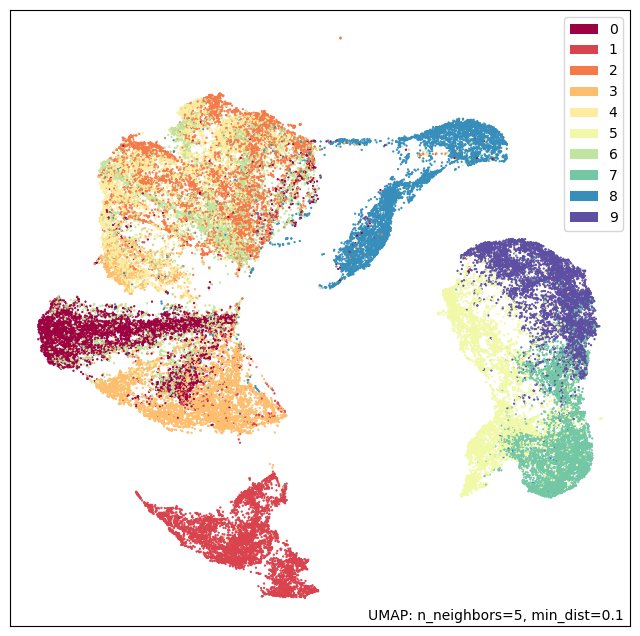

In [4]:
umap.plot.points(mapper, labels=fmnist_labels)

### Quality Assessment

#### Shepard plot of embeddings

In [5]:
def shepard_plot(
    *,
    embeddings,
    data,
    labels,
    xlabel="Original high-dimensional distances",
    ylabel="UMAP embedding distances",
    title="Shepard Plot with Sampling and Trend Line",
    sample_size=10000
):
    # Sample a subset of the data
    if len(data) > sample_size:
        sample_indices = np.random.choice(len(data), size=sample_size, replace=False)
    else:
        sample_indices = np.arange(len(data))

    sampled_data = data[sample_indices]
    sampled_embeddings = embeddings[sample_indices]

    # # Compute pairwise distances for the sampled subset
    original_distances = pairwise_distances(sampled_data)
    embedding_distances = pairwise_distances(sampled_embeddings)

    original_distances_flat = original_distances.flatten()
    embedding_distances_flat = embedding_distances.flatten()

    # Sample points to plot
    plot_sample_indices = np.random.choice(
        len(original_distances_flat), size=sample_size, replace=False
    )
    sampled_original_distances = original_distances_flat[plot_sample_indices]
    sampled_embedding_distances = embedding_distances_flat[plot_sample_indices]

    # Shepard plot with increased opacity
    plt.figure(figsize=(10, 8))
    plt.scatter(
        sampled_original_distances,
        sampled_embedding_distances,
        alpha=0.4,
        s=1,
        label="Data points",
    )

    # Trend line using linear regression
    lr = LinearRegression()
    lr.fit(sampled_original_distances.reshape(-1, 1), sampled_embedding_distances)
    trend_line = lr.predict(np.sort(sampled_original_distances).reshape(-1, 1))
    plt.plot(
        np.sort(sampled_original_distances),
        trend_line,
        color="red",
        linewidth=2,
        label="Trend line",
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

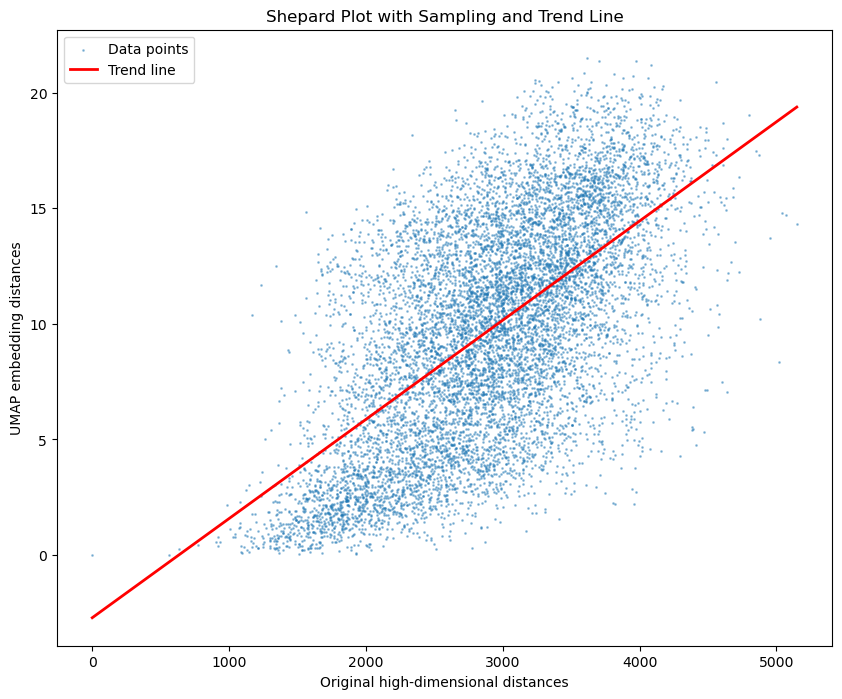

In [8]:
shepard_plot(
    embeddings=embedding, data=fmnist_data, labels=fmnist_labels
)

The Shepard plot shows that the UMAP embedding preserves relative distances between points well. A trend line close to the diagonal indicates generally good embedding quality. The scattering of points around a trendline is typical for dimensionality reduction, and UMAP preserves local distances better than global distances. UMAP effectively preserves the structure of data, which is beneficial for tasks such as clustering and nearest neighbor searching.

#### kNN classifier

Aby ocenić jakość embeddingu UMAP za pomocą kNN, można porównać dokładność klasyfikacji na oryginalnych danych i na danych po embeddingu. 

In [4]:
def knn_accuracy(
    *,
    reducer,
    data,
    labels,
    n_neighbors = 5
):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, random_state=RANDOM_STATE
    )
    
    X_train_embedding = reducer.fit_transform(X_train)
    X_test_embedding = reducer.transform(X_test)

    knn_original = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_original.fit(X_train, y_train)
    y_pred_original = knn_original.predict(X_test)

    knn_embedding = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_embedding.fit(X_train_embedding, y_train)
    y_pred_embedding = knn_embedding.predict(X_test_embedding)

    accuracy_original = accuracy_score(y_test, y_pred_original)
    accuracy_embedding = accuracy_score(y_test, y_pred_embedding)

    return accuracy_original, accuracy_embedding

In [10]:
accuracy_original, accuracy_embedding = knn_accuracy(
    reducer=umap.UMAP(n_neighbors=5),
    data=fmnist_data,
    labels=fmnist_labels
)

print(f"Original data accuracy: {accuracy_original:.2f}")
print(f"UMAP data accuracy: {accuracy_embedding:.2f}")

Original data accuracy: 0.85
UMAP data accuracy: 0.76


The classification accuracy on the original data is 0.8528, while on the UMAP embedding, it is 0.7642. This indicates that UMAP effectively preserves most of the important local structures of the data, allowing for relatively high classification performance with kNN in the reduced space. Although there is a drop in accuracy, which suggests some loss of global information, the embedding still retains key features necessary for classification. This demonstrates that UMAP is useful for dimensionality reduction, maintaining a balance between reducing complexity and preserving data integrity.

### Changing UMAP parameters

/home/mateu/miniconda3/envs/py_3_10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/mateu/miniconda3/envs/py_3_10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/mateu/miniconda3/envs/py_3_10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/mateu/miniconda3/envs/py_3_10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 

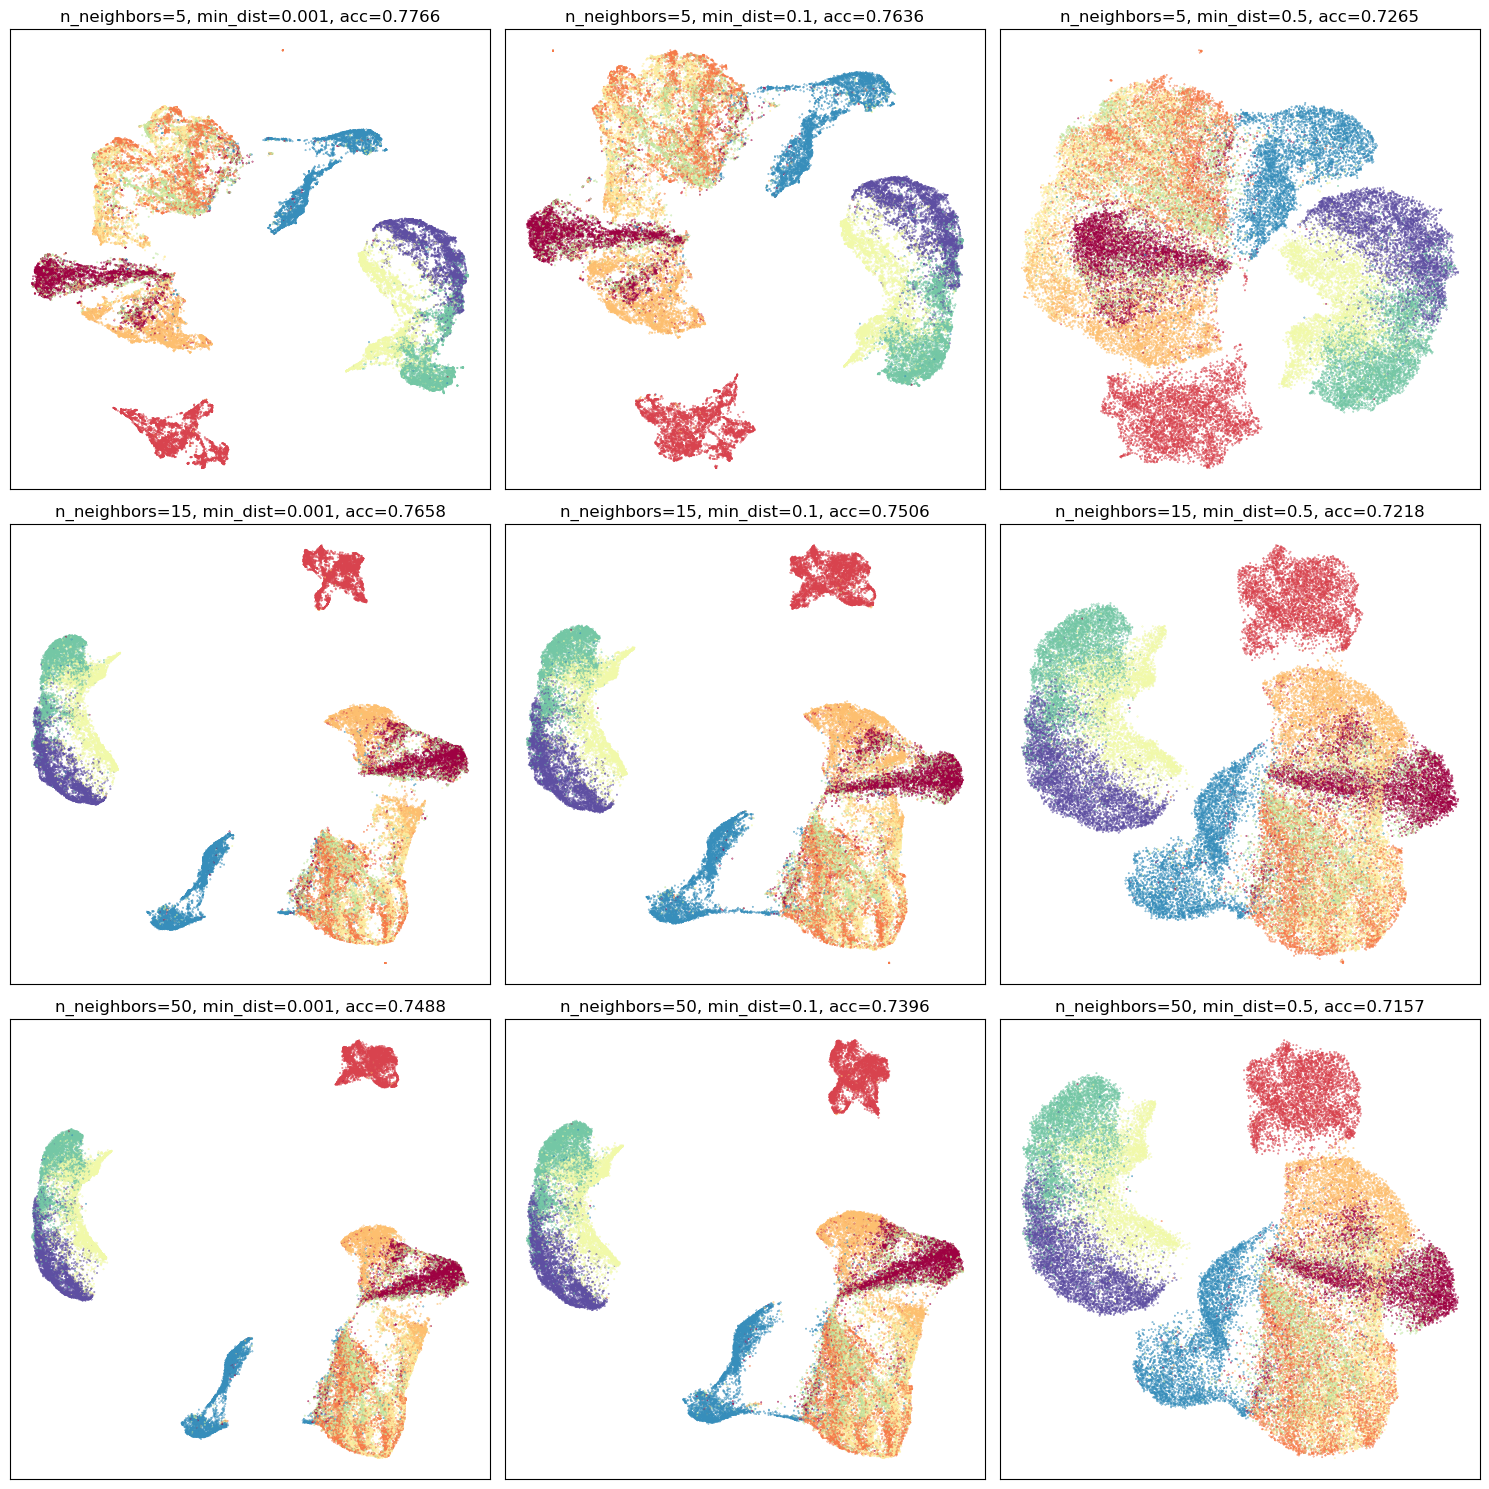

In [11]:
# Parameters to test
n_neighbors_values = [5, 15, 50]
min_dist_values = [0.001, 0.1, 0.5]

# Prepare the plot
fig, axes = plt.subplots(len(n_neighbors_values), len(min_dist_values), figsize=(15, 15))

X_train, X_test, y_train, y_test = train_test_split(
    fmnist_data, fmnist_labels, test_size=0.2, random_state=RANDOM_STATE
)

for i, n_neighbors in enumerate(n_neighbors_values):
    for j, min_dist in enumerate(min_dist_values):
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric="euclidean",
            random_state=RANDOM_STATE,
        )

        X_train_embedding = reducer.fit_transform(X_train)
        X_test_embedding = reducer.transform(X_test)

        knn_embedding = KNeighborsClassifier(n_neighbors=5)
        knn_embedding.fit(X_train_embedding, y_train)
        y_pred_embedding = knn_embedding.predict(X_test_embedding)

        accuracy_embedding = accuracy_score(y_test, y_pred_embedding)

        axes[i, j].scatter(X_train_embedding[:, 0], X_train_embedding[:, 1], c=y_train, cmap='Spectral', s=0.1)
        axes[i, j].set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}, acc={accuracy_embedding:.4f}')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

Changing the UMAP parameters `n_neighbors` and `min_dist` has a noticeable impact on the resulting embeddings and their classification performance. When `n_neighbors` is set to a low value (e.g., 5), the embeddings preserve more local structure, resulting in tighter clusters and higher k-NN accuracy, with the highest accuracy observed at 0.7766 for `min_dist=0.001`. As `n_neighbors` increases to 50, the embeddings capture more global structure, leading to less distinct clusters and a decrease in accuracy to around 0.7396-0.7488. Similarly, lowering `min_dist` to 0.001 results in more compact clusters and better preservation of local details, enhancing classification accuracy.

## t-SNE
(task 2)

### Embeddings

In [1]:
NUMBER_OF_CORES = 12

In [9]:
tsne = TSNE(n_jobs=NUMBER_OF_CORES)

embedding_tsne = tsne.fit_transform(fmnist_data)

/tmp/ipykernel_37490/3465962926.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(vis_x, vis_y, c=fmnist_labels, cmap=plt.cm.get_cmap("jet", 10), marker=".", s=10)


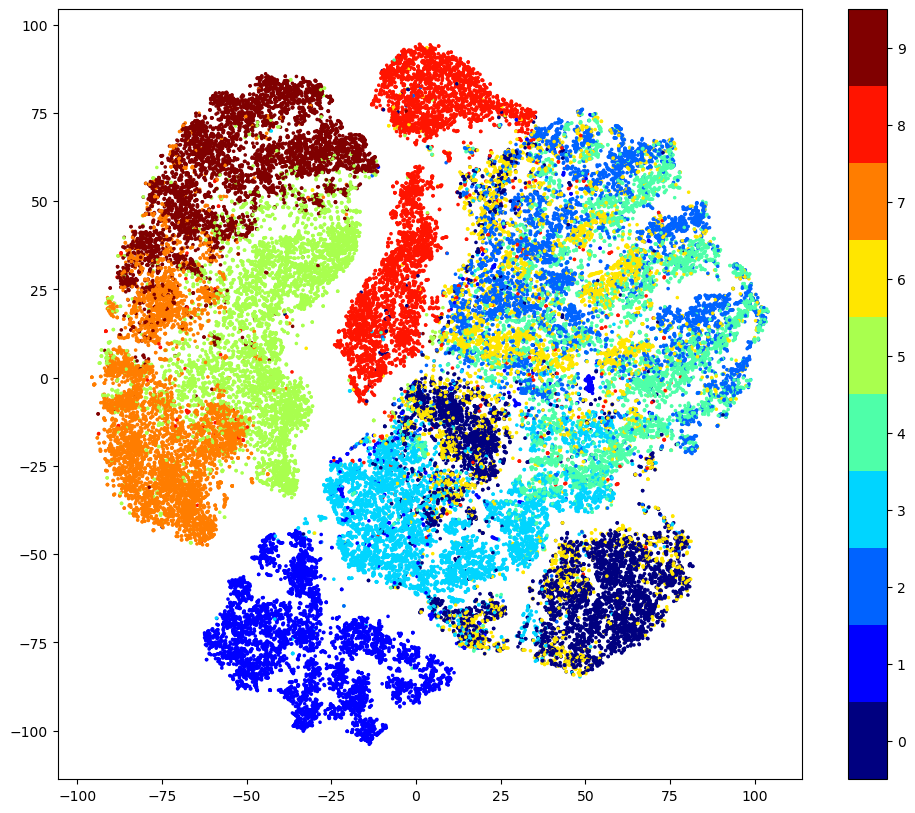

In [8]:
vis_x = embedding_tsne[:, 0]
vis_y = embedding_tsne[:, 1]

plt.figure(figsize=(12, 10))
plt.scatter(vis_x, vis_y, c=fmnist_labels, cmap=plt.cm.get_cmap("jet", 10), marker=".", s=10)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

### Quality Assessment

#### Shepard plot of embeddings

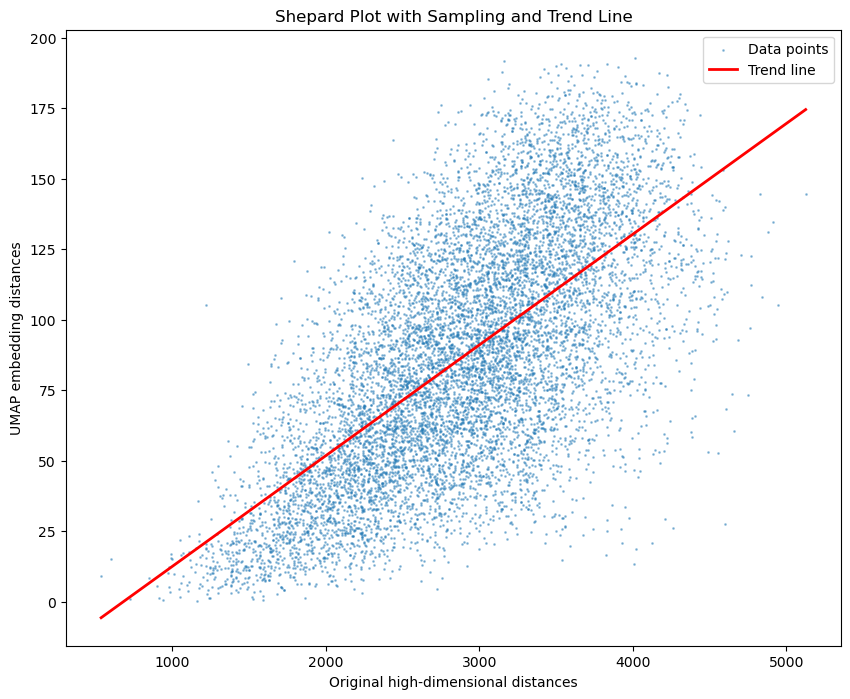

In [10]:
shepard_plot(
    embeddings=embedding_tsne,
    data=fmnist_data,
    labels=fmnist_labels,
    sample_size=10000
)

The Shepard plot for t-SNE shows a nearly linear relationship between the original high-dimensional distances and the embedding distances. The trend line closely follows the diagonal, indicating that t-SNE effectively preserves the relative distances between points. There is a noticeable spread of points around the trend line, suggesting some variability in how t-SNE preserves these distances. The plot demonstrates that t-SNE maintains the local structure of the data well, though there is some variability in preserving exact distances from the high-dimensional space.

#### Changing kNN parameters

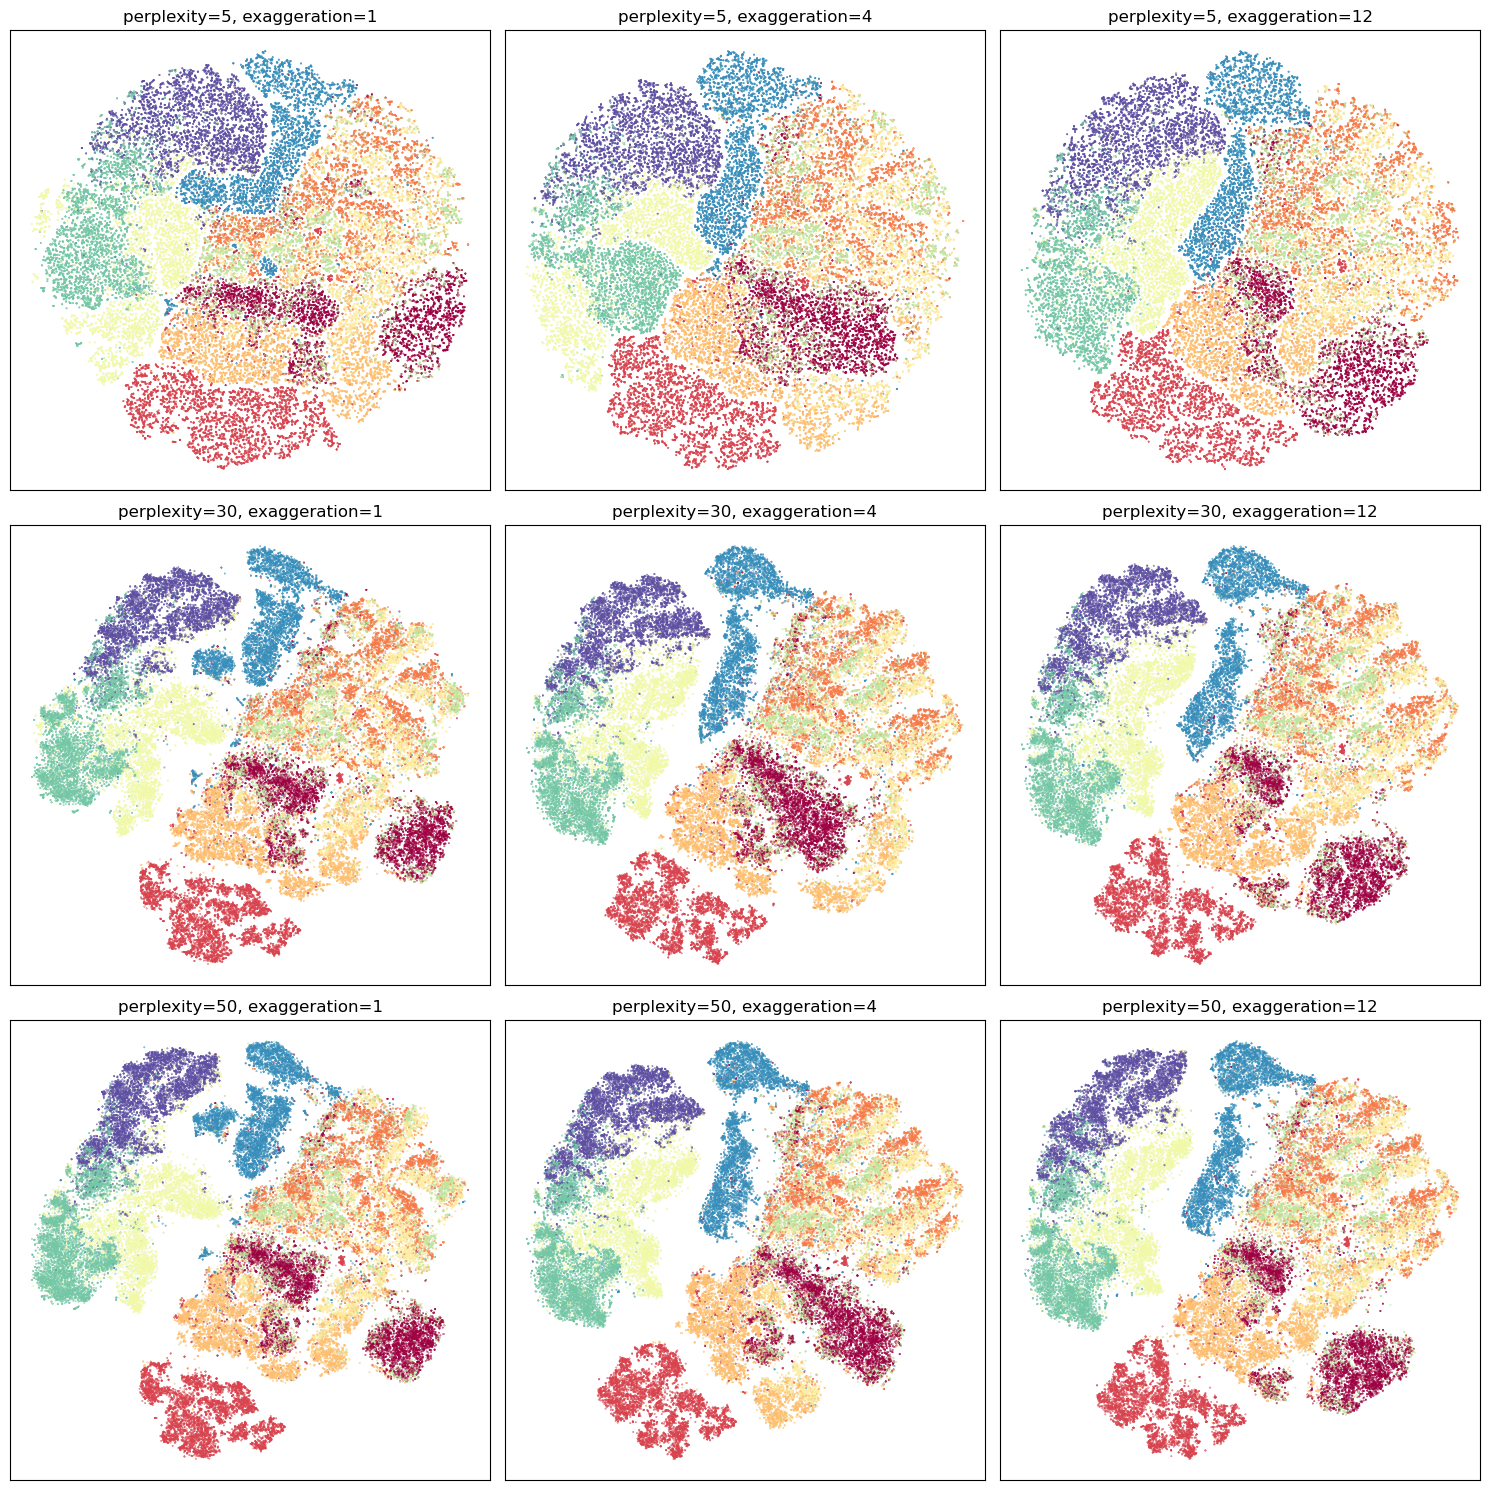

In [24]:
# Parameters to test
perplexity_values = [5, 30, 50]
exaggeration_values = [1, 4, 12]

# Prepare the plot
fig, axes = plt.subplots(
    len(perplexity_values), len(exaggeration_values), figsize=(15, 15)
)

for i, perplexity in enumerate(perplexity_values):
    for j, exaggeration in enumerate(exaggeration_values):
        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            early_exaggeration=exaggeration,
            random_state=RANDOM_STATE,
        )

        X = tsne.fit_transform(fmnist_data)

        axes[i, j].scatter(X[:, 0], X[:, 1], c=fmnist_labels, cmap='Spectral', s=0.1)
        axes[i, j].set_title(f'perplexity={perplexity}, exaggeration={exaggeration}')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

Lower perplexity (top row) emphasizes local structures with tight, distinct clusters. Medium perplexity (middle row) balances local and global structures, spreading clusters out more. Higher perplexity (bottom row) focuses on global structure, leading to more overlap and less distinct clusters.

Exaggeration affects cluster separation: low exaggeration (left column) keeps clusters compact, medium exaggeration (middle column) increases separation, and high exaggeration (right column) spreads clusters significantly, potentially distorting the overall structure.

### Differences

### t-SNE vs. UMAP: Quality and Efficiency of Embedding

**t-SNE:**
- **Quality:**
  - Excels at preserving local structures.
  - Less effective at capturing global structures.
  - Sensitive to the perplexity parameter.
  - Can produce variable results across runs.
- **Efficiency:**
  - Computationally intensive (time complexity $O(N^2)$).
  - Does not scale well to large datasets.
  - Memory-intensive.

**UMAP:**
- **Quality:**
  - Balances local and global structure preservation.
  - Provides clearer cluster separation.
  - Less sensitive to parameter settings.
  - More consistent embeddings across runs.
- **Efficiency:**
  - Faster with time complexity $O(N \log N)$.
  - Scales better for large datasets.
  - More memory efficient.

UMAP took about 40 seconds on my machine, whilst tSNE took more than 5 minutes to calculate embeddings.